In [202]:
import bisect
import sys
from test_functions import test_functions
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
rec = 100000
sys.setrecursionlimit(rec)

In [203]:
def F(func, dots, x):
    f_s = [func(i) - tau * L * np.abs(x - i) for (i, _, _, _, L) in dots[2:-3]]
    return max(f_s)

In [204]:
def nl(func, dots, lam_max_ind, x_max_ind, counter):
    min_value, min_index = min([(y, i) for i, (_, y, _, _, _) in enumerate(dots)])

    if abs(dots[min_index][0] - dots[min_index + 1][0]) < epsilon_stop:
        func_values = [func(x) for (x, _, _, _, _) in dots[2:-2]]
        return min(func_values), counter

    counter += 1
    x_max_start = dots[x_max_ind + 1][0] - dots[x_max_ind][0]
    lam_max_start = (func(dots[lam_max_ind + 1][0]) - func(dots[lam_max_ind][0])) / (dots[lam_max_ind + 1][0] - dots[lam_max_ind][0])

    new_dot = ((dots[min_index][0] + dots[min_index + 1][0]) / 2) - ((func(dots[min_index + 1][0]) -
                                                                   func(dots[min_index][0])) / (2 * tau * dots[min_index][4]))

    new_index = bisect.bisect_left(dots, [new_dot, float("inf"), -float("inf"), 0 , 0])

    bisect.insort_left(dots, [new_dot, float("inf"), -float("inf"), 0 , 0])

    xs = []
    lambdas = []
    xs.append(-float("inf")), xs.append(-float("inf")), lambdas.append(-float("inf")), lambdas.append(-float("inf"))
    for i in range(2, len(dots) - 3):
        xs.append(dots[i + 1][0] - dots[i][0])
        lambdas.append(abs(func(dots[i + 1][0]) - func(dots[i][0])) / xs[-1])
    xs.append(-float("inf")), lambdas.append(-float("inf")), xs.append(-float("inf")), lambdas.append(-float("inf"))
    xs.append(-float("inf")), lambdas.append(-float("inf"))

    lambdas_1 = max(lambdas[new_index - 3], lambdas[new_index - 2], lambdas[new_index - 1])
    lambdas_2 = max(lambdas[new_index - 2], lambdas[new_index - 1], lambdas[new_index])
    lambdas_3 = max(lambdas[new_index - 1], lambdas[new_index], lambdas[new_index + 1])
    lambdas_4 = max(lambdas[new_index], lambdas[new_index + 1], lambdas[new_index + 2])

    ll = [0] * 4
    ll[0], ll[1], ll[2], ll[3] = lambdas_1, lambdas_2, lambdas_3, lambdas_4

    for i in (0, 1, 2, 3):
        if 1 < new_index - 2 + i < len(dots) - 3:
            dots[new_index - 2 + i][3] = ll[i]

    x_max_finish, x_max_ind = max((x, i) for i, x in enumerate(xs))
    lam_max_finish, lam_max_ind = max((lam, i) for i, lam in enumerate(lambdas))

    if x_max_start == x_max_finish and lam_max_start == lam_max_finish:
        gamma_1 = lam_max_finish * (dots[new_index][0] - dots[new_index - 1][0]) / x_max_start
        gamma_2 = lam_max_finish * (dots[new_index + 1][0] - dots[new_index][0]) / x_max_start
        gg = []
        gg.append(gamma_1), gg.append(gamma_2)
        HH = [0] * 4
        cc = [0] * 4


        H_1 = max(lambdas_1, dots[new_index - 2][2], epsilon)
        H_2 = max(lambdas_2, gamma_1, epsilon)
        H_3 = max(lambdas_3, gamma_2, epsilon)
        H_4 = max(lambdas_4, dots[new_index + 1][2], epsilon)

        HH[0], HH[1], HH[2], HH[3] = H_1, H_2, H_3, H_4

        char_1 = ((func(dots[new_index - 1][0]) + func(dots[new_index - 2][0])) / 2) - (H_1 * tau / 2) * (dots[new_index - 1][0] - dots[new_index - 2][0])
        char_2 = ((func(dots[new_index][0]) + func(dots[new_index - 1][0])) / 2) - (H_2 * tau / 2) * (dots[new_index][0] - dots[new_index - 1][0])
        char_3 = ((func(dots[new_index + 1][0]) + func(dots[new_index][0])) / 2) - (H_3 * tau / 2) * (dots[new_index + 1][0] - dots[new_index][0])
        char_4 = ((func(dots[new_index + 2][0]) + func(dots[new_index + 1][0])) / 2) - (H_4 * tau / 2) * (dots[new_index + 2][0] - dots[new_index + 1][0])

        cc[0], cc[1], cc[2], cc[3] = char_1, char_2, char_3, char_4


        for i in (0, 1 ,2 ,3):
            if 1 < new_index - 2 + i < len(dots) - 3:
                if i == 1 or i == 2:
                    dots[new_index - 2 + i] = [dots[new_index - 2 + i][0], cc[i], gg[i - 1], ll[i], HH[i]]
                else:
                    dots[new_index - 2 + i] = [dots[new_index - 2 + i][0], cc[i], dots[new_index - 2 + i][2], ll[i], HH[i]]


    else:
        gamma_s = []
        H_s = []
        char_s = []
        lambdaz = [lam for (_, _, _, lam, _) in dots]
        for i in range(2, len(dots) - 3):
            gamma_s.append((lam_max_finish / x_max_finish) * (dots[i + 1][0] - dots[i][0]))
            H_s.append(max(lambdaz[i], gamma_s[-1], epsilon))
            char_s.append((func(dots[i + 1][0]) + func(dots[i][0]) / 2) - (H_s[-1] * tau / 2) * (dots[i + 1][0] - dots[i][0]))
            dots[i] = [dots[i][0], char_s[-1], gamma_s[-1], lambdaz[i], H_s[-1]]

    return nl(func, dots, lam_max_ind, x_max_ind, counter)

In [205]:
def i_nl(func, dots, lam_max_ind, x_max_ind, counter):
    min_value, min_index = max([(y, -i) for i, (_, y, _, _, _) in enumerate(dots)])
    min_index *= -1

    if abs(dots[min_index][0] - dots[min_index + 1][0]) < epsilon_stop:
        func_values = [func(x) for (x, _, _, _, _) in dots[2:-2]]
        return min(func_values), counter

    counter += 1
    x_max_start = dots[x_max_ind + 1][0] - dots[x_max_ind][0]
    lam_max_start = (func(dots[lam_max_ind + 1][0]) - func(dots[lam_max_ind][0])) / (dots[lam_max_ind + 1][0] - dots[lam_max_ind][0])

    new_dot = ((dots[min_index][0] + dots[min_index + 1][0]) / 2) - ((func(dots[min_index + 1][0]) -
                                                                   func(dots[min_index][0])) / (2 * tau * dots[min_index][4]))

    new_index = bisect.bisect_left(dots, [new_dot, -float("inf"), -float("inf"), 0 , 0])

    bisect.insort_left(dots, [new_dot, -float("inf"), -float("inf"), 0 , 0])

    xs = []
    lambdas = []
    xs.append(-float("inf")), xs.append(-float("inf")), lambdas.append(-float("inf")), lambdas.append(-float("inf"))
    for i in range(2, len(dots) - 3):
        xs.append(dots[i + 1][0] - dots[i][0])
        lambdas.append(abs(func(dots[i + 1][0]) - func(dots[i][0])) / xs[-1])
    xs.append(-float("inf")), lambdas.append(-float("inf")), xs.append(-float("inf")), lambdas.append(-float("inf"))
    xs.append(-float("inf")), lambdas.append(-float("inf"))

    lambdas_1 = max(lambdas[new_index - 3], lambdas[new_index - 2], lambdas[new_index - 1])
    lambdas_2 = max(lambdas[new_index - 2], lambdas[new_index - 1], lambdas[new_index])
    lambdas_3 = max(lambdas[new_index - 1], lambdas[new_index], lambdas[new_index + 1])
    lambdas_4 = max(lambdas[new_index], lambdas[new_index + 1], lambdas[new_index + 2])

    ll = [0] * 4
    ll[0], ll[1], ll[2], ll[3] = lambdas_1, lambdas_2, lambdas_3, lambdas_4

    for i in (0, 1, 2, 3):
        if 1 < new_index - 2 + i < len(dots) - 3:
            dots[new_index - 2 + i][3] = ll[i]

    x_max_finish, x_max_ind = max((x, i) for i, x in enumerate(xs))
    lam_max_finish, lam_max_ind = max((lam, i) for i, lam in enumerate(lambdas))

    if x_max_start == x_max_finish and lam_max_start == lam_max_finish:
        gamma_1 = lam_max_finish * (dots[new_index][0] - dots[new_index - 1][0]) / x_max_start
        gamma_2 = lam_max_finish * (dots[new_index + 1][0] - dots[new_index][0]) / x_max_start
        gg = []
        gg.append(gamma_1), gg.append(gamma_2)
        HH = [0] * 4
        cc = [0] * 4


        H_1 = max(lambdas_1, dots[new_index - 2][2], epsilon)
        H_2 = max(lambdas_2, gamma_1, epsilon)
        H_3 = max(lambdas_3, gamma_2, epsilon)
        H_4 = max(lambdas_4, dots[new_index + 1][2], epsilon)

        HH[0], HH[1], HH[2], HH[3] = H_1, H_2, H_3, H_4

        char_1 = H_1 * (dots[new_index - 1][0] - dots[new_index - 2][0]) + ((
                        (func(dots[new_index - 1][0]) - func(dots[new_index - 2][0])) ** 2) / (
                                     H_1 * (dots[new_index - 1][0] - dots[new_index - 2][0]))) - 2 * (
                                     func(dots[new_index - 1][0]) + func(dots[new_index - 2][0]))

        char_2 = H_2 * (dots[new_index][0] - dots[new_index - 1][0]) + ((
                        (func(dots[new_index][0]) - func(dots[new_index - 1][0])) ** 2) / (
                                     H_2 * (dots[new_index][0] - dots[new_index - 1][0]))) - 2 * (
                                     func(dots[new_index][0]) + func(dots[new_index - 1][0]))

        char_3 = H_3 * (dots[new_index + 1][0] - dots[new_index][0]) + ((
                        (func(dots[new_index + 1][0]) - func(dots[new_index][0])) ** 2) / (
                                     H_3 * (dots[new_index + 1][0] - dots[new_index][0]))) - 2 * (
                                     func(dots[new_index + 1][0]) + func(dots[new_index][0]))

        char_4 = H_4 * (dots[new_index + 2][0] - dots[new_index + 1][0]) + ((
                        (func(dots[new_index + 2][0]) - func(dots[new_index + 1][0])) ** 2) / (
                                     H_4 * (dots[new_index + 2][0] - dots[new_index + 1][0]))) - 2 * (
                                     func(dots[new_index + 2][0]) + func(dots[new_index + 1][0]))

        cc[0], cc[1], cc[2], cc[3] = char_1, char_2, char_3, char_4


        for i in (0, 1 ,2 ,3):
            if 1 < new_index - 2 + i < len(dots) - 3:
                if i == 1 or i == 2:
                    dots[new_index - 2 + i] = [dots[new_index - 2 + i][0], cc[i], gg[i - 1], ll[i], HH[i]]
                else:
                    dots[new_index - 2 + i] = [dots[new_index - 2 + i][0], cc[i], dots[new_index - 2 + i][2], ll[i], HH[i]]


    else:
        gamma_s = []
        H_s = []
        char_s = []
        lambdaz = [lam for (_, _, _, lam, _) in dots]
        for i in range(2, len(dots) - 3):
            gamma_s.append((lam_max_finish / x_max_finish) * (dots[i + 1][0] - dots[i][0]))
            H_s.append(max(lambdaz[i], gamma_s[-1], epsilon))
            char_s.append(H_s[-1] * (dots[i + 1][0] - dots[i][0]) + ((
                        (func(dots[i + 1][0]) - func(dots[i][0])) ** 2) / (
                                     H_s[-1] * (dots[i + 1][0] - dots[i][0]))) - 2 * (
                                     func(dots[i + 1][0]) + func(dots[i][0])))
            dots[i] = [dots[i][0], char_s[-1], gamma_s[-1], lambdaz[i], H_s[-1]]

    return i_nl(func, dots, lam_max_ind, x_max_ind, counter)

In [211]:
epsilon = 10 ** (-6)
tau = 1.5

In [212]:
for index, func in enumerate(test_functions):
    a, b, L, counter = func.interval[0], func.interval[1], func.L, 0
    epsilon_stop = (b - a) * (10 ** -4)
    lam_max, x_max = abs(func.f(b) - func.f(a)) / (b - a), b - a
    H = max(lam_max * (b - a) / x_max, lam_max, epsilon)
    char = (func.f(b) + func.f(a)) / 2 - tau * H * (b - a) / 2
    dots = [[-float("inf"), float("inf"), -float("inf"), -float("inf"), float("inf")], [-float("inf"), float("inf"), -float("inf"), -float("inf"), float("inf")], [a, char, lam_max * (b - a) / x_max, lam_max, H], [b, float("inf"), -float("inf"), -float("inf"), -float("inf")], [float("inf"), float("inf"), -float("inf"), -float("inf"), float("inf")], [float("inf"), float("inf"), -float("inf"), -float("inf"), float("inf")]]
    minval, count = nl(func.f, dots, 2, 2, counter)
    print(index + 1, minval, count)

1 -29678.777630382425 14
2 -1.899599347601276 33


/Users/evgeny/code/metopt/HSE_OptimizationMethods/test_functions.py:34: RuntimeWarning: invalid value encountered in sin
  return -sum(k * np.sin((k + 1) * x + k) for k in range(1, 6))
/Users/evgeny/code/metopt/HSE_OptimizationMethods/test_functions.py:50: RuntimeWarning: invalid value encountered in sin
  return (3 * x - 1.4) * np.sin(18 * x)


3 -12.031248979640202 104
4 -3.8504507082997614 35
5 -1.4890719653898783 61
6 -0.8242380925954974 54
7 -1.601307535519572 36
8 -14.50789318888324 75
9 -1.9059609503227883 54
10 -7.916726554656664 68


/Users/evgeny/code/metopt/HSE_OptimizationMethods/test_functions.py:82: RuntimeWarning: invalid value encountered in sin
  return np.sin(x) + np.sin(2 * x / 3)
/Users/evgeny/code/metopt/HSE_OptimizationMethods/test_functions.py:115: RuntimeWarning: invalid value encountered in double_scalars
  return -(x ** (2 / 3)) + np.cbrt(x ** 2 - 1)


11 -1.4999999283710628 67
12 -0.9999999910338584 61
13 -1.5874010519497233 157
14 -0.7886853433330983 44
15 -0.035533898721633275 75
16 7.515924235504253 66
17 7.000003595878269 76
18 5.699753571140463e-08 39
19 -7.815674542970686 31
20 -0.0634905285811428 37


In [213]:
xarrays, yarrays, ogarrays = [], [], []

for index, func in enumerate(test_functions):
    x_arr = np.linspace(func.interval[0], func.interval[1], 1200)
    y, og = [], []
    a, b, L, counter = func.interval[0], func.interval[1], func.L, 0
    epsilon_stop = (b - a) * (10 ** -4)
    lam_max, x_max = abs(func.f(b) - func.f(a)) / (b - a), b - a
    H = max(lam_max * (b - a) / x_max, lam_max, epsilon)
    char = (func.f(b) + func.f(a)) / 2 - tau * H * (b - a) / 2
    dots = [[-float("inf"), float("inf"), -float("inf"), -float("inf"), float("inf")], [-float("inf"), float("inf"), -float("inf"), -float("inf"), float("inf")], [a, char, lam_max * (b - a) / x_max, lam_max, H], [b, float("inf"), -float("inf"), -float("inf"), -float("inf")], [float("inf"), float("inf"), -float("inf"), -float("inf"), float("inf")], [float("inf"), float("inf"), -float("inf"), -float("inf"), float("inf")]]
    minval, count = nl(func.f, dots, 2, 2, counter)
    for i in x_arr:
        y.append(func.f(i))
        og.append(F(func.f, dots, i))
    xarrays.append(x_arr)
    yarrays.append(y)
    ogarrays.append(og)

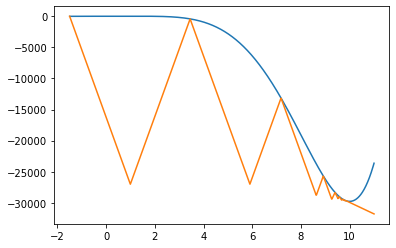

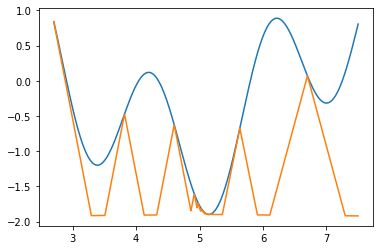

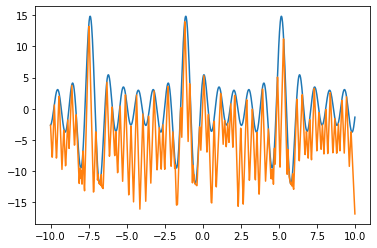

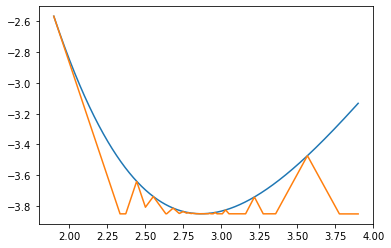

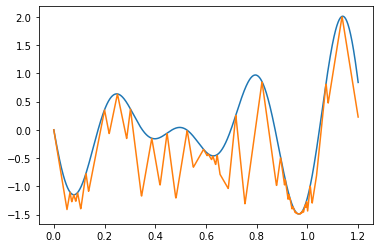

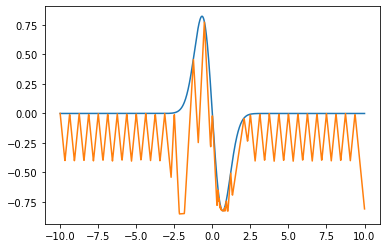

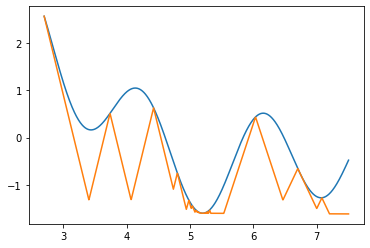

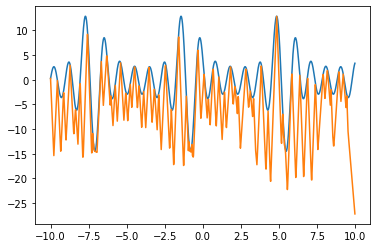

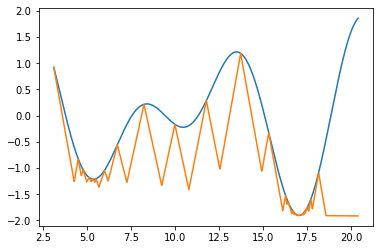

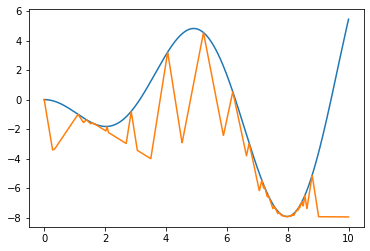

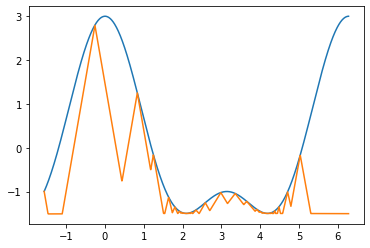

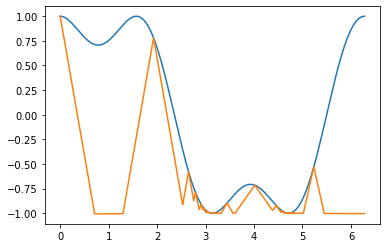

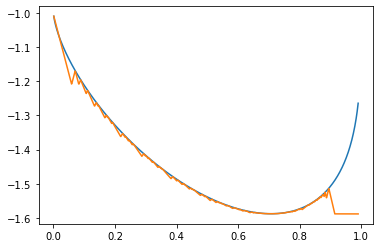

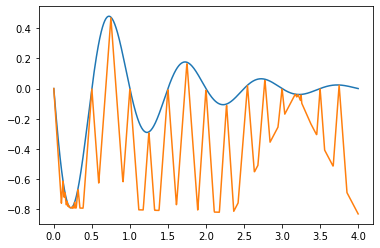

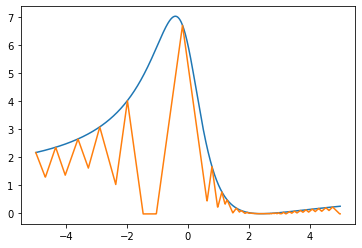

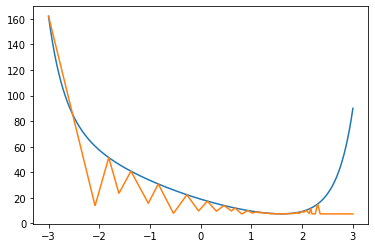

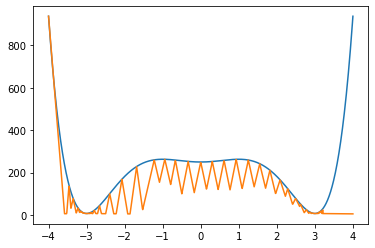

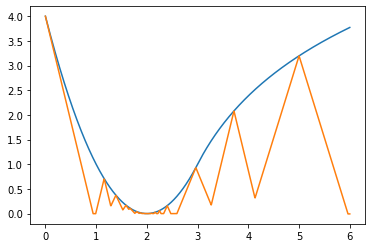

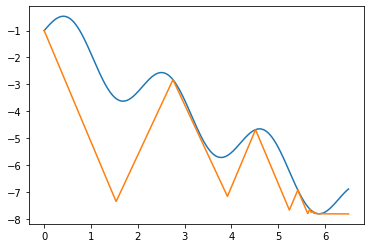

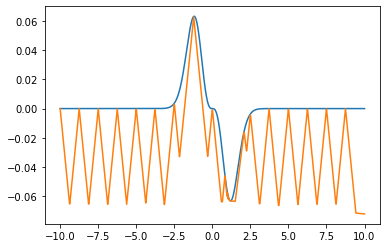

In [214]:
for index in range(20):
    plt.plot(xarrays[index], yarrays[index])
    plt.plot(xarrays[index], ogarrays[index])
    plt.show()

In [215]:
for index, func in enumerate(test_functions):
    a, b, L, counter = func.interval[0], func.interval[1], func.L, 0
    epsilon_stop = (b - a) * (10 ** -4)
    lam_max, x_max = abs(func.f(b) - func.f(a)) / (b - a), b - a
    H = max(lam_max * (b - a) / x_max, lam_max, epsilon)
    char = (H * (b - a)) + ((func.f(b) - func.f(a)) ** 2) / (H * (b - a)) - 2 * (func.f(b) + func.f(a))
    dots = [[-float("inf"), -float("inf"), -float("inf"), -float("inf"), float("inf")], [-float("inf"), -float("inf"), -float("inf"), -float("inf"), float("inf")], [a, char, lam_max * (b - a) / x_max, lam_max, H], [b, -float("inf"), -float("inf"), -float("inf"), -float("inf")], [float("inf"), -float("inf"), -float("inf"), -float("inf"), float("inf")], [float("inf"), -float("inf"), -float("inf"), -float("inf"), float("inf")]]
    minval, count = i_nl(func.f, dots, 2, 2, counter)
    print(index + 1, minval, count)


1 -29747.609459215146 11
2 -1.899599288563476 21
3 -11.907266594202062 14
4 -3.8255888269030804 11
5 -1.4890724546865295 25
6 -0.8139564305682653 16
7 -1.5990011276431604 14
8 -3.6136800018443793 36
9 -1.0448720107622926 8
10 -1.6590132629196082 9
11 -1.4999999955377301 45
12 -0.9999999743441035 44
13 -1.587401051901951 26
14 -0.038828396854568036 16
15 0.03669724770642203 8
16 7.51592430803316 28
17 250.0 28
18 0.16093521033704025 9
19 -7.815674523213134 19
20 -0.06349052873483862 22


/Users/evgeny/code/metopt/HSE_OptimizationMethods/test_functions.py:58: RuntimeWarning: invalid value encountered in sin
  return -(x + np.sin(x)) * np.exp(-x ** 2)
/Users/evgeny/code/metopt/HSE_OptimizationMethods/test_functions.py:90: RuntimeWarning: invalid value encountered in sin
  return -x * np.sin(x)
/Users/evgeny/code/metopt/HSE_OptimizationMethods/test_functions.py:178: RuntimeWarning: invalid value encountered in sin
  return (np.sin(x) - x) * np.exp(-x ** 2)
